In [1]:
!pip install ultralytics torch torchvision opencv-python pillow boto3

In [2]:
import torch
from ultralytics import YOLO
# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [3]:
import os

In [4]:
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [5]:
!nvidia-smi

Tue Mar 25 06:10:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    On  |   00000000:00:1E.0 Off |                    0 |
|  0%   35C    P8             18W /  300W |       4MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
import boto3

In [7]:
def download_files_from_bucket(file,bucket):
     '''
     this function is for downloading the files from the bucket to the local instance
     '''    
     bucket_name = bucket
     file_key = file
     local_file_path = file
     s3 = boto3.client('s3')
     s3.download_file(bucket_name, file_key, local_file_path)    
     print(f"File downloaded to {local_file_path}")

In [8]:
download_files_from_bucket('stanford-car-dataset-by-classes-folder.zip','pgp-capstone-project')

File downloaded to stanford-car-dataset-by-classes-folder.zip


In [9]:
zip_file_path = 'stanford-car-dataset-by-classes-folder.zip'
!unzip -oq stanford-car-dataset-by-classes-folder.zip 

#### **For Car Detection Problem**

In [10]:
import numpy as np
import pandas as pd
from pathlib import Path
import shutil
from matplotlib import pyplot as plt
from matplotlib import patches
import cv2
import yaml
import glob # for file path handling
from PIL import Image # For image loading and manipulation
import xml.etree.ElementTree as ET # For handling XML annotations (common for object detection datasets)
from sklearn.model_selection import train_test_split #for model selection
from sklearn.preprocessing import LabelEncoder
from ultralytics import YOLO

#### **Data Loading**

**Loading Training Annotations, Test Annotations and image class**

In [11]:
train_annotations_df = pd.read_csv( "anno_train.csv",header=None)

In [12]:
test_annotations_df = pd.read_csv( "anno_test.csv",header=None)

In [13]:
image_class_df = pd.read_csv( "names.csv",header=None)

**renaming columns of train, test and image class**

In [14]:
train_annotations_df.rename(columns={0:"image_name",1:"xmin",2:"ymin",3:'xmax',4:'ymax',5:'image_class'},inplace=True)

In [15]:
test_annotations_df.rename(columns={0:"image_name",1:"xmin",2:"ymin",3:'xmax',4:'ymax',5:'image_class'},inplace=True)

In [16]:
image_class_df.rename(columns={0:'image_name'},inplace=True)

**displaying first 5 values of class names and annotations**

In [17]:
image_class_df.head()

image_name
0  AM General Hummer SUV 2000
1         Acura RL Sedan 2012
2         Acura TL Sedan 2012
3        Acura TL Type-S 2008
4        Acura TSX Sedan 2012

In [18]:
train_annotations_df.head(5)

image_name  xmin  ymin  xmax  ymax  image_class
0  00001.jpg    39   116   569   375           14
1  00002.jpg    36   116   868   587            3
2  00003.jpg    85   109   601   381           91
3  00004.jpg   621   393  1484  1096          134
4  00005.jpg    14    36   133    99          106

In [19]:
test_annotations_df.head()

image_name  xmin  ymin  xmax  ymax  image_class
0  00001.jpg    30    52   246   147          181
1  00002.jpg   100    19   576   203          103
2  00003.jpg    51   105   968   659          145
3  00004.jpg    67    84   581   407          187
4  00005.jpg   140   151   593   339          185

**finding out the min and max value of the classifications in train and test**

In [20]:
train_annotations_df['image_class'].min(),train_annotations_df['image_class'].max()

(1, 196)

In [21]:
test_annotations_df['image_class'].min(),test_annotations_df['image_class'].max()


(1, 196)

**finding out the missing classes in training and testing**

**the classnames in image_class_df starts with 0 and in annotations starts with 1 hence adding 1 to imageclass_df**

In [22]:
expected_class_ids = set(range(1,len(image_class_df)+1))

In [23]:
min(expected_class_ids),max(expected_class_ids)

(1, 196)

In [24]:
train_class_ids = set(train_annotations_df["image_class"].unique())

In [25]:
test_class_ids = set(test_annotations_df["image_class"].unique())

In [26]:
missing_in_train = expected_class_ids - train_class_ids

In [27]:
missing_in_test = expected_class_ids - test_class_ids

In [28]:
missing_in_train

set()

In [29]:
missing_in_test

set()

In [30]:
missing_train_class_names = image_class_df.iloc[list(missing_in_train)].values.flatten().tolist()


In [31]:
missing_test_class_names = image_class_df.iloc[list(missing_in_test)].values.flatten().tolist()

In [32]:
print(f"Missing class IDs in training set: {sorted(missing_in_train)}")
print(f"Missing class names in training set: {missing_train_class_names}")

Missing class IDs in training set: []
Missing class names in training set: []


In [33]:
print(f"Missing class IDs in testing set: {sorted(missing_in_test)}")
print(f"Missing class names in testing set: {missing_test_class_names}")

Missing class IDs in testing set: []
Missing class names in testing set: []


**Adding one more column in image_class_df to have class_id from 1 to 196 to be in sync with annotation data set. this will be helpful in searching and merging of data**

In [34]:
image_class_df.reset_index(drop=True, inplace=True)

In [35]:
image_class_df.insert(0, "class_id", image_class_df.index + 1)

In [36]:
image_class_df.head()

class_id                  image_name
0         1  AM General Hummer SUV 2000
1         2         Acura RL Sedan 2012
2         3         Acura TL Sedan 2012
3         4        Acura TL Type-S 2008
4         5        Acura TSX Sedan 2012

**Creation Of Directories for YOLO Processing**

-dataset/

-├── images/
 
-│   ├── train/

-│   ├── val/

-│   └── test/

-├── labels/

-│   ├── train/

-│   ├── val/

-│   └── test/ 

In [37]:
dataset_path = Path("dataset")

In [38]:
dirs = [
    dataset_path / "images" / "train",
    dataset_path / "images" / "val",
    dataset_path / "images" / "test",
    dataset_path / "labels" / "train",
    dataset_path / "labels" / "val",
    dataset_path / "labels" / "test"
]

In [39]:
for d in dirs:
    d.mkdir(parents=True, exist_ok=True)

**Splitting the training Data into train and validation**

In [40]:
train_annotations_df["image_class"] = train_annotations_df["image_class"].astype(int)

In [41]:
train_df, val_df = train_test_split(
    train_annotations_df,
    test_size=0.2,
    stratify=train_annotations_df["image_class"],
    random_state=42
)

**checking the shape of train and validation data set**

In [42]:
train_df.shape

(6515, 6)

In [43]:
val_df.shape

(1629, 6)

**Mapping classid and clasnames**

In [44]:
class_map = {
    class_id: name.strip().replace("/", "-")
    for class_id, name in zip(image_class_df["class_id"], image_class_df["image_name"])
}

In [45]:
class_map

{1: 'AM General Hummer SUV 2000',
 2: 'Acura RL Sedan 2012',
 3: 'Acura TL Sedan 2012',
 4: 'Acura TL Type-S 2008',
 5: 'Acura TSX Sedan 2012',
 6: 'Acura Integra Type R 2001',
 7: 'Acura ZDX Hatchback 2012',
 8: 'Aston Martin V8 Vantage Convertible 2012',
 9: 'Aston Martin V8 Vantage Coupe 2012',
 10: 'Aston Martin Virage Convertible 2012',
 11: 'Aston Martin Virage Coupe 2012',
 12: 'Audi RS 4 Convertible 2008',
 13: 'Audi A5 Coupe 2012',
 14: 'Audi TTS Coupe 2012',
 15: 'Audi R8 Coupe 2012',
 16: 'Audi V8 Sedan 1994',
 17: 'Audi 100 Sedan 1994',
 18: 'Audi 100 Wagon 1994',
 19: 'Audi TT Hatchback 2011',
 20: 'Audi S6 Sedan 2011',
 21: 'Audi S5 Convertible 2012',
 22: 'Audi S5 Coupe 2012',
 23: 'Audi S4 Sedan 2012',
 24: 'Audi S4 Sedan 2007',
 25: 'Audi TT RS Coupe 2012',
 26: 'BMW ActiveHybrid 5 Sedan 2012',
 27: 'BMW 1 Series Convertible 2012',
 28: 'BMW 1 Series Coupe 2012',
 29: 'BMW 3 Series Sedan 2012',
 30: 'BMW 3 Series Wagon 2012',
 31: 'BMW 6 Series Convertible 2007',
 32: 

**Moving the images and labels to the respective yolo directories.**

**The bounding boxes are normalized for YOLO format**

In [46]:
def move_and_create_labels(df, src_dir, dst_img_dir, dst_lbl_dir, class_map):
    for _, row in df.iterrows():
        img_name = row["image_name"]
        class_id = int(row["image_class"])
        class_id_yolo = class_id - 1  # YOLO expects 0-based
        class_name = class_map[class_id]

        # Source image
        src_img_path = src_dir / class_name / img_name

        # Destination paths
        dst_img_path = dst_img_dir / img_name
        dst_lbl_path = dst_lbl_dir / img_name.replace(".jpg", ".txt")

        if not src_img_path.exists():
            print(f"Missing image: {src_img_path}")
            continue

        # Copy image
        shutil.copy(src_img_path, dst_img_path)

        # Read image dimensions
        img = cv2.imread(str(src_img_path))
        if img is None:
            print(f"Unreadable image: {src_img_path}")
            continue

        h, w = img.shape[:2]

        # Normalize bounding box
        x_center_raw = ((row["xmin"] + row["xmax"]) / 2) / w
        y_center_raw = ((row["ymin"] + row["ymax"]) / 2) / h
        width_raw = (row["xmax"] - row["xmin"]) / w
        height_raw = (row["ymax"] - row["ymin"]) / h
        
        #outlier logging.
        if any(v > 1.1 or v < 0 for v in [x_center_raw, y_center_raw, width_raw, height_raw]):
            print(f"Out-of-bounds bbox in {img_name}: "
              f"x_center={x_center_raw:.2f}, y_center={y_center_raw:.2f}, "
              f"w={width_raw:.2f}, h={height_raw:.2f}")
        
        # clamping outliers to make it to safe YOLO format
        x_center = min(max(x_center_raw, 0), 1)
        y_center = min(max(y_center_raw, 0), 1)
        width = min(max(width_raw, 0), 1)
        height = min(max(height_raw, 0), 1)
        
        # Write YOLO-format label
        with open(dst_lbl_path, "w") as f:
            f.write(f"{class_id_yolo} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    print(f"Done: {len(df)} samples → {dst_img_dir.name}/ + {dst_lbl_dir.name}/")

In [47]:
src_base_train_dir = Path("car_data/car_data/train")
src_base_test_dir = Path("car_data/car_data/test") 

In [48]:
dst_img_train = Path("dataset/images/train")
dst_lbl_train = Path("dataset/labels/train")

In [49]:
dst_img_val = Path("dataset/images/val")
dst_lbl_val = Path("dataset/labels/val")

In [50]:
dst_img_test = Path("dataset/images/test")
dst_lbl_test = Path("dataset/labels/test")

**Moving the images and Labels**

In [51]:
move_and_create_labels(train_df, src_base_train_dir, dst_img_train, dst_lbl_train, class_map)

Out-of-bounds bbox in 07389.jpg: x_center=0.67, y_center=0.40, w=1.15, h=0.56
Done: 6515 samples → train/ + train/


In [52]:
move_and_create_labels(val_df, src_base_train_dir, dst_img_val, dst_lbl_val, class_map)

Done: 1629 samples → val/ + val/


In [53]:
move_and_create_labels(test_annotations_df, src_base_test_dir, dst_img_test, dst_lbl_test, class_map)

Done: 8041 samples → test/ + test/


**Creating Data.yml for YOLO**

In [54]:
dataset_path = Path("dataset")

In [55]:
class_names = (
    image_class_df
    .sort_values("class_id")["image_name"]
    .str.replace("/", "-", regex=False)   
    .tolist()
)

In [56]:
data_yaml = {
    "path": str(dataset_path.resolve()),  # absolute path to dataset
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",
    "nc": len(class_names),
    "names": class_names
}

In [57]:
with open(dataset_path / "data.yaml", "w") as f:
    yaml.dump(data_yaml, f)

In [58]:
print("data.yaml generated at:", dataset_path / "data.yaml")

data.yaml generated at: dataset/data.yaml


**THE YOLO MODEL**

In [59]:
model = YOLO("yolov8l.pt")  # Options: yolov8n.pt (small), yolov8m.pt (medium), yolov8l.pt (large)

100%|██████████| 83.7M/83.7M [00:00<00:00, 330MB/s]


In [60]:
train_metrics = model.train(data="dataset/data.yaml", epochs=50, imgsz=640, batch=16, device="cuda")

Ultralytics 8.3.96 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA A10G, 22503MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

100%|██████████| 5.35M/5.35M [00:00<00:00, 294MB/s]


AMP: checks passed ✅


train: Scanning /home/ec2-user/SageMaker/dataset/labels/train... 6515 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6515/6515 [00:05<00:00, 1281.16it/s]


train: New cache created: /home/ec2-user/SageMaker/dataset/labels/train.cache


val: Scanning /home/ec2-user/SageMaker/dataset/labels/val... 1629 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1629/1629 [00:01<00:00, 1160.03it/s]

val: New cache created: /home/ec2-user/SageMaker/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=5e-05, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.64G     0.5089      4.433      1.127          6        640: 100%|██████████| 408/408 [02:29<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:12<00:00,  4.19it/s]


                   all       1629       1629      0.547     0.0741     0.0517     0.0475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      13.7G     0.4619      3.422       1.07          6        640: 100%|██████████| 408/408 [02:25<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:12<00:00,  4.24it/s]


                   all       1629       1629      0.319      0.287      0.189      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      13.7G     0.4697      2.793      1.059          7        640: 100%|██████████| 408/408 [02:24<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]


                   all       1629       1629      0.407      0.479      0.428        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      13.7G     0.4501      2.289      1.041          9        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]


                   all       1629       1629      0.512      0.579      0.598      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      13.8G     0.4342      1.927      1.027          9        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629       0.61      0.619       0.69      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      13.8G     0.4264      1.646      1.017          8        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629      0.716       0.72      0.799      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      13.9G     0.4227      1.468      1.014          9        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629      0.767      0.746      0.838       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      13.9G     0.4093      1.286      1.007          9        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629      0.745      0.793      0.859      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50        14G     0.4072      1.161      1.003          9        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]

                   all       1629       1629      0.808      0.809      0.886      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50        14G     0.3992      1.073     0.9972          8        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629      0.826      0.831      0.897      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50        14G     0.3952     0.9961     0.9933          4        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629      0.855      0.843      0.907      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      14.1G     0.3882     0.9306     0.9911          5        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]

                   all       1629       1629       0.83      0.832      0.905      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      14.1G      0.389      0.893     0.9893         12        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]

                   all       1629       1629      0.866      0.869      0.925      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      14.2G     0.3911     0.8514     0.9895         10        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]

                   all       1629       1629      0.863      0.861      0.926      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      14.2G     0.3801     0.8062     0.9839          8        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629      0.869      0.866      0.925      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      14.3G     0.3775     0.7593     0.9837          6        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]

                   all       1629       1629      0.887       0.88      0.933      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      14.3G     0.3749     0.7263     0.9807          9        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]

                   all       1629       1629      0.896      0.879      0.935      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      14.3G     0.3767     0.7065     0.9795         12        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629      0.882      0.885      0.938      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      14.4G     0.3689      0.681     0.9754          8        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:12<00:00,  4.25it/s]

                   all       1629       1629      0.884      0.908      0.938      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      14.4G     0.3681     0.6616     0.9778          7        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629      0.885      0.898      0.939      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      14.7G     0.3583     0.6223     0.9684          9        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]

                   all       1629       1629      0.885      0.905      0.944      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      14.9G     0.3622     0.6299     0.9741          9        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]

                   all       1629       1629       0.88      0.906      0.941      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      15.2G     0.3538      0.603     0.9685          8        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]

                   all       1629       1629      0.891      0.907      0.943      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      15.4G      0.355     0.5885      0.968         10        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]

                   all       1629       1629      0.889      0.909      0.942      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      15.6G     0.3547     0.5707     0.9674          9        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629        0.9      0.896       0.94      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      15.9G     0.3501     0.5642     0.9646         11        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]

                   all       1629       1629      0.886      0.912      0.941      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      16.1G     0.3481     0.5512     0.9647          6        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.25it/s]

                   all       1629       1629      0.894      0.918      0.945      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      16.4G     0.3423     0.5349     0.9594         10        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629      0.891      0.911      0.946      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      16.6G     0.3419      0.524     0.9615          7        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]

                   all       1629       1629      0.913       0.91      0.949      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      16.9G     0.3388     0.5033     0.9564         12        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629      0.896      0.903      0.942      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      17.1G     0.3379     0.5025      0.959          4        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629      0.896      0.919      0.945      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      17.3G     0.3332     0.4733     0.9553          7        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]

                   all       1629       1629       0.91      0.911      0.946      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      17.6G     0.3256     0.4605     0.9511          8        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629      0.899      0.914      0.946      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      17.8G     0.3242     0.4568     0.9508         10        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629      0.918      0.904      0.947      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      18.1G      0.325     0.4441       0.95          6        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]

                   all       1629       1629      0.899      0.917      0.949      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      18.3G     0.3223      0.443     0.9512          7        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629      0.916      0.908      0.945      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      18.5G     0.3185     0.4394     0.9505          6        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]

                   all       1629       1629      0.896      0.922      0.946      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      18.8G     0.3173     0.4205     0.9491         10        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]

                   all       1629       1629      0.913      0.905      0.947      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50        19G     0.3155     0.4094     0.9447          9        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629      0.913      0.916      0.945      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      19.3G     0.3144     0.4104     0.9451          6        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629      0.922      0.905      0.948      0.899


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      19.5G     0.2305      0.203     0.8821          3        640: 100%|██████████| 408/408 [02:23<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:12<00:00,  4.25it/s]

                   all       1629       1629      0.916      0.899      0.944      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      19.7G     0.2253     0.1914      0.881          3        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.27it/s]

                   all       1629       1629      0.914      0.905      0.943      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50        20G     0.2217     0.1777     0.8787          3        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]

                   all       1629       1629      0.912      0.907      0.946        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      10.3G     0.2171     0.1736      0.878          3        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.28it/s]

                   all       1629       1629      0.903      0.918      0.944      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      13.6G     0.2137     0.1633     0.8716          3        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.29it/s]

                   all       1629       1629      0.903      0.915      0.947        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      13.6G     0.2069     0.1573       0.87          3        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.29it/s]

                   all       1629       1629      0.916      0.915      0.947      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      13.6G     0.2042      0.155     0.8685          3        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.29it/s]

                   all       1629       1629      0.924      0.909      0.948      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      13.6G      0.202      0.152     0.8665          3        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.28it/s]

                   all       1629       1629      0.913      0.915      0.946      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      13.6G     0.1981     0.1473     0.8668          3        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.29it/s]

                   all       1629       1629      0.922      0.908      0.948      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      13.6G      0.196     0.1437     0.8636          3        640: 100%|██████████| 408/408 [02:23<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.28it/s]

                   all       1629       1629      0.913      0.918      0.949      0.902



50 epochs completed in 2.186 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 88.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 88.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.96 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA A10G, 22503MiB)
Model summary (fused): 112 layers, 43,757,724 parameters, 0 gradients, 165.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.46it/s]


                   all       1629       1629      0.924      0.909      0.948      0.902
AM General Hummer SUV 2000          9          9      0.867          1      0.962      0.903
   Acura RL Sedan 2012          6          6      0.939      0.833      0.922      0.922
   Acura TL Sedan 2012          9          9      0.996          1      0.995       0.78
  Acura TL Type-S 2008          8          8      0.973          1      0.995      0.995
  Acura TSX Sedan 2012          8          8      0.875          1      0.982      0.925
Acura Integra Type R 2001          9          9      0.968          1      0.995      0.974
Acura ZDX Hatchback 2012          8          8      0.963          1      0.995      0.983
Aston Martin V8 Vantage Convertible 2012          9          9      0.856      0.662      0.829      0.783
Aston Martin V8 Vantage Coupe 2012          8          8      0.863      0.791      0.884      0.803
Aston Martin Virage Convertible 2012          6          6      0.817  

**Training Metrics**

In [64]:
print(f"Precision:     {train_metrics.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall:        {train_metrics.results_dict['metrics/recall(B)']:.4f}")
print(f"mAP@0.5:       {train_metrics.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5:0.95:  {train_metrics.results_dict['metrics/mAP50-95(B)']:.4f}")
print(f"fitness:       {train_metrics.results_dict['fitness']:.4f}")

Precision:     0.9235
Recall:        0.9094
mAP@0.5:       0.9477
mAP@0.5:0.95:  0.9020
fitness:       0.9066


In [65]:
pd.DataFrame([train_metrics.results_dict]).to_csv("YOLO_train_metrics.csv", index=False)

**Observation Of Training Model**
- **Precision: 92.35% → Most of the model's predictions are correct (low false positives).**
- **Recall: 90.94% → The model detects most actual cars (low false negatives).**
- **mAP\@0.5: 94.77% → Excellent accuracy in detecting and localizing objects.**
- **mAP\@0.5-0.95: 90.20% → Strong generalization across varying IoU thresholds.**
- **Fitness: 0.9066 → Combined score used for selecting the best model checkpoint.**

***The model is highly accurate, well-generalized, and robust — ready for deployment.***

**Using Validation Data**

In [66]:
metrics = model.val()

Ultralytics 8.3.96 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA A10G, 22503MiB)
Model summary (fused): 112 layers, 43,757,724 parameters, 0 gradients, 165.7 GFLOPs


val: Scanning /home/ec2-user/SageMaker/dataset/labels/val.cache... 1629 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1629/1629 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:17<00:00,  5.85it/s]


                   all       1629       1629      0.923       0.91      0.948      0.901
AM General Hummer SUV 2000          9          9      0.867          1      0.962      0.917
   Acura RL Sedan 2012          6          6      0.938      0.833      0.922      0.922
   Acura TL Sedan 2012          9          9      0.996          1      0.995       0.78
  Acura TL Type-S 2008          8          8      0.973          1      0.995      0.995
  Acura TSX Sedan 2012          8          8      0.874          1      0.982      0.925
Acura Integra Type R 2001          9          9      0.968          1      0.995      0.974
Acura ZDX Hatchback 2012          8          8      0.963          1      0.995      0.983
Aston Martin V8 Vantage Convertible 2012          9          9      0.857      0.664      0.829      0.782
Aston Martin V8 Vantage Coupe 2012          8          8      0.863      0.792      0.884      0.803
Aston Martin Virage Convertible 2012          6          6      0.817  

In [67]:
print(f"Precision:     {metrics.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall:        {metrics.results_dict['metrics/recall(B)']:.4f}")
print(f"mAP@0.5:       {metrics.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5:0.95:  {metrics.results_dict['metrics/mAP50-95(B)']:.4f}")
print(f"fitness:       {metrics.results_dict['fitness']:.4f}")

Precision:     0.9228
Recall:        0.9096
mAP@0.5:       0.9475
mAP@0.5:0.95:  0.9013
fitness:       0.9059


**Observation For Validation Metrics:**
- **Precision: 92.28% → Very few false positives**
- **Recall: 90.96% → Most actual cars are correctly detected**
- **mAP\@0.5: 94.75% → Excellent object detection accuracy**
- **mAP\@0.5-0.95: 90.13% → Strong generalization across IoU thresholds**
- **Fitness: 0.9059 → High combined score used to select the best model**
  
***The model shows high accuracy and strong generalization — it’s well-trained and deployment-ready.***

**Graph Display**

In [68]:
log_df = pd.read_csv("runs/detect/train/results.csv")

In [69]:
%matplotlib inline

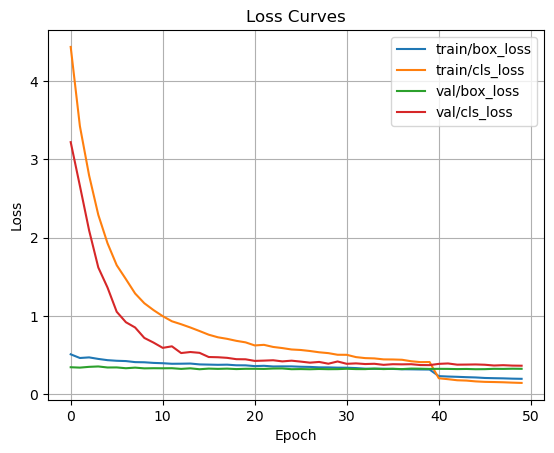

In [70]:
log_df[["train/box_loss", "train/cls_loss", "val/box_loss", "val/cls_loss"]].plot(title="Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

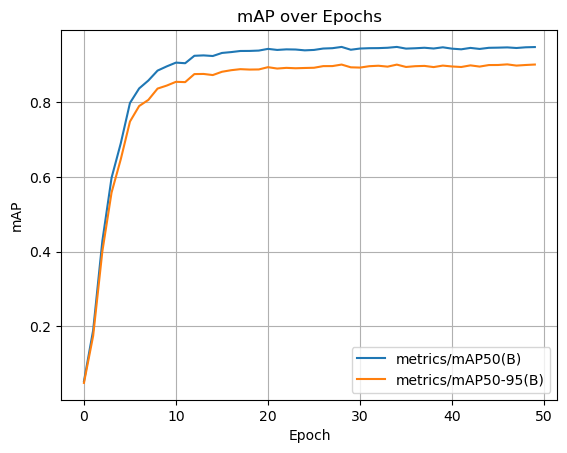

In [71]:
log_df[["metrics/mAP50(B)", "metrics/mAP50-95(B)"]].plot(title="mAP over Epochs")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.grid()
plt.show()

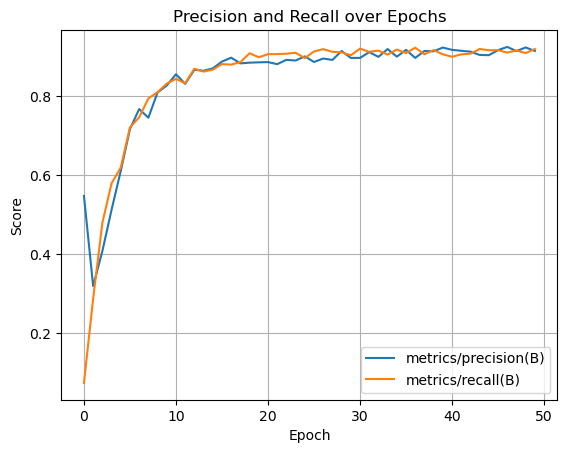

In [72]:
log_df[["metrics/precision(B)", "metrics/recall(B)"]].plot(title="Precision and Recall over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid()
plt.show()

**Observation**
- **Loss**
    - **Both training and validation losses (box & class) decrease steadily and converge.**
    - **No sign of overfitting — validation losses track closely with training losses.**
    - **The model is found to be learning well and generalizing effectively**
- **mAP over Epochs**
   - **mAP@0.5 and mAP@0.5:0.95 increase rapidly and stabilize above 0.94 and 0.90 respectively.**
   - **The model gives a good object detection**
- **Precision & Recall**
    - **Both precision and recall improve over epochs and stabilize around 0.92.**
    - **The model is found to be making accurate and consistent predictions**   - 



image 1/1 /home/ec2-user/SageMaker/dataset/images/val/00001.jpg: 448x640 1 Audi TT Hatchback 2011, 60.7ms
Speed: 1.9ms preprocess, 60.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


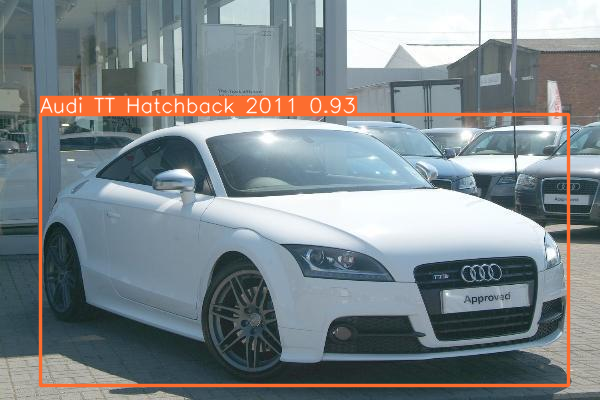

In [73]:
results = model("dataset/images/val/00001.jpg")  
results[0].show()


image 1/1 /home/ec2-user/SageMaker/dataset/images/val/00094.jpg: 416x640 1 Ford GT Coupe 2006, 60.8ms
Speed: 1.4ms preprocess, 60.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


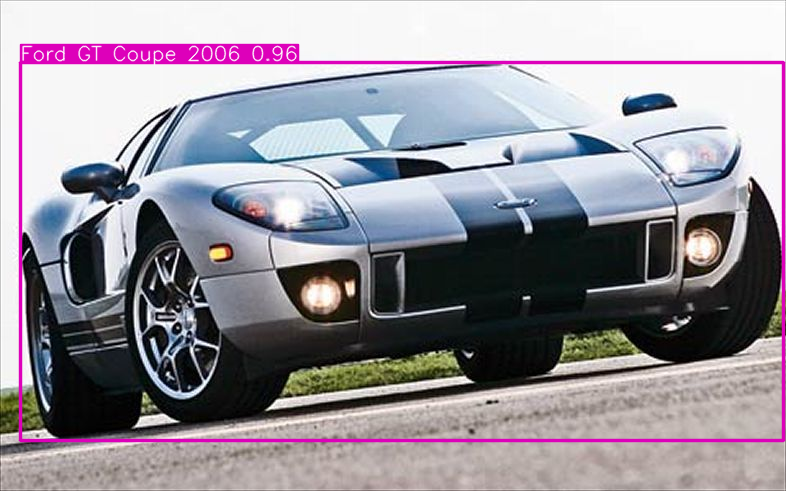

In [74]:
results = model("dataset/images/val/00094.jpg")  
results[0].show()

**Observation**
- **The model has correctly predicted the validation Images**

**Predicting using the test data set**

In [75]:
test_metrics = model.val(split='test', save=True, save_txt=True)

Ultralytics 8.3.96 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA A10G, 22503MiB)


val: Scanning /home/ec2-user/SageMaker/dataset/labels/test... 8041 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8041/8041 [00:06<00:00, 1267.83it/s]


val: New cache created: /home/ec2-user/SageMaker/dataset/labels/test.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 503/503 [01:38<00:00,  5.08it/s]


                   all       8041       8041      0.932       0.91      0.949      0.899
AM General Hummer SUV 2000         44         44      0.922      0.977      0.976       0.93
   Acura RL Sedan 2012         32         32      0.776      0.844      0.838      0.838
   Acura TL Sedan 2012         43         43      0.809      0.885      0.935      0.826
  Acura TL Type-S 2008         42         42      0.997      0.976      0.991      0.981
  Acura TSX Sedan 2012         40         40      0.969      0.778      0.906      0.883
Acura Integra Type R 2001         44         44      0.896       0.98      0.982      0.962
Acura ZDX Hatchback 2012         39         39      0.991      0.897      0.918      0.892
Aston Martin V8 Vantage Convertible 2012         45         45      0.774        0.8      0.824      0.761
Aston Martin V8 Vantage Coupe 2012         41         41      0.919      0.826      0.915      0.855
Aston Martin Virage Convertible 2012         33         33      0.923  

In [84]:
print(f"Precision:     {test_metrics.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall:        {test_metrics.results_dict['metrics/recall(B)']:.4f}")
print(f"mAP@0.5:       {test_metrics.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5:0.95:  {test_metrics.results_dict['metrics/mAP50-95(B)']:.4f}")
print(f"fitness:       {test_metrics.results_dict['fitness']:.4f}")

Precision:     0.9322
Recall:        0.9100
mAP@0.5:       0.9492
mAP@0.5:0.95:  0.8986
fitness:       0.9037


**Observation**
- **Precision: 93.22% → Very few false positives**
- **Recall: 91.00% → Most actual objects are detected**
- **mAP\@0.5: 94.92% → Excellent detection accuracy**
- **mAP\@0.5:0.95: 89.86% → Strong generalization across IoU thresholds**
- **Fitness: 0.9037 → High overall model quality**
- 
***The model is highly accurate and well-balanced in the test data set.***


In [76]:
results = model("dataset/images/test/05766.jpg")


image 1/1 /home/ec2-user/SageMaker/dataset/images/test/05766.jpg: 480x640 1 Bentley Continental GT Coupe 2007, 61.9ms
Speed: 1.7ms preprocess, 61.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


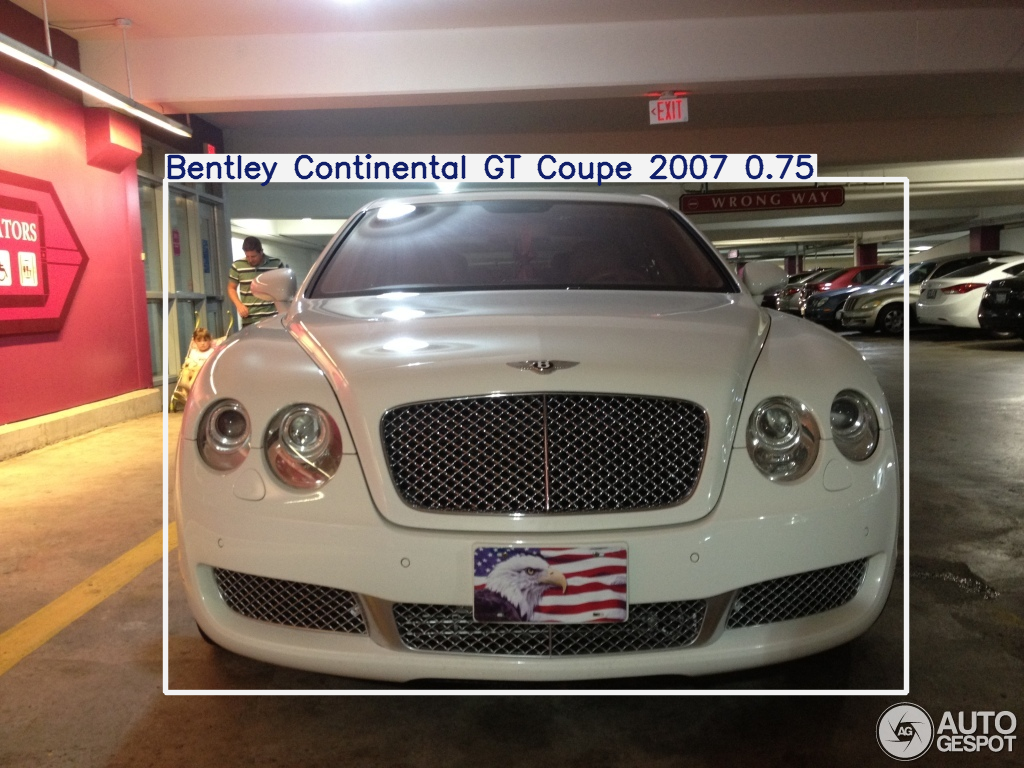

In [77]:
results[0].show()

In [78]:
results = model("dataset/images/test/00008.jpg")


image 1/1 /home/ec2-user/SageMaker/dataset/images/test/00008.jpg: 416x640 1 Mercedes-Benz S-Class Sedan 2012, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


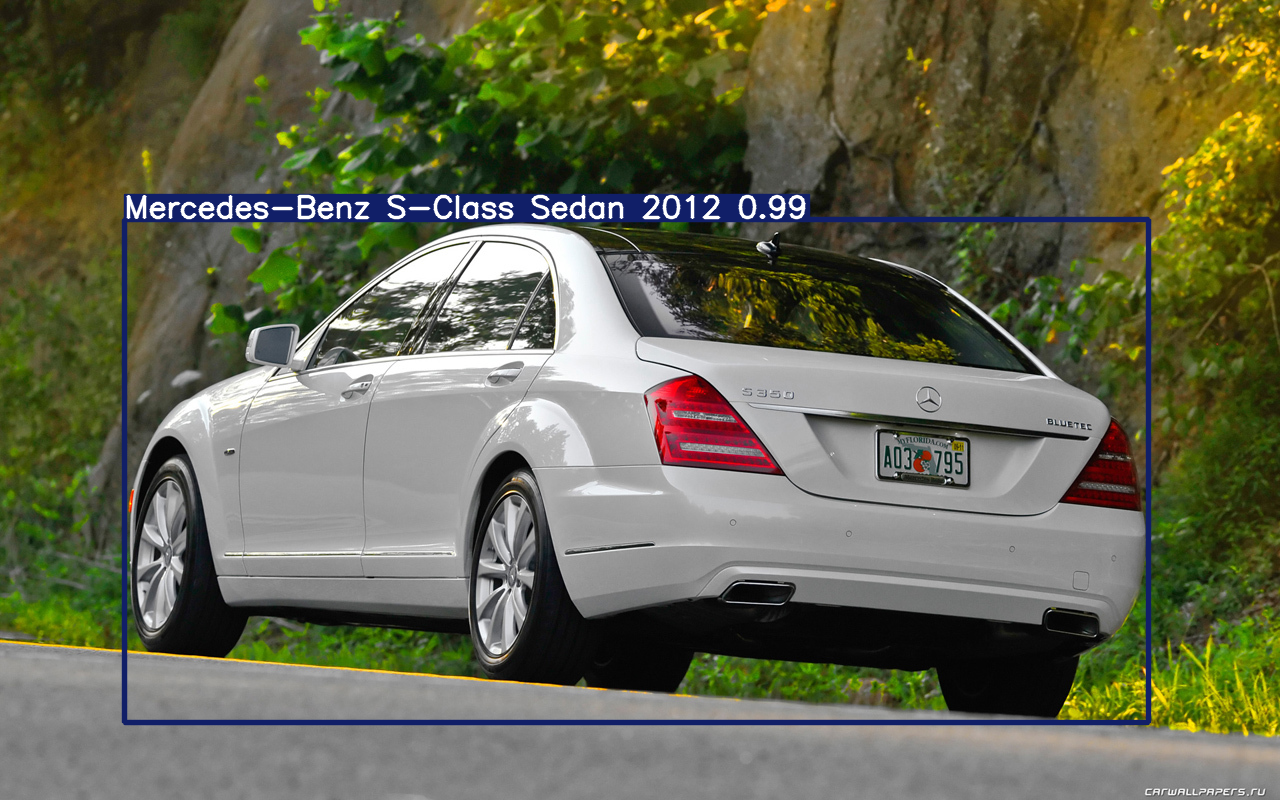

In [79]:
results[0].show()

**Observation**
- ***The prediction of the cars are on dot***

**Prediction For Untrained Images**

In [80]:
results = model("DodgeCaliber2025.jpg")


image 1/1 /home/ec2-user/SageMaker/DodgeCaliber2025.jpg: 384x640 1 Dodge Caliber Wagon 2007, 62.1ms
Speed: 1.2ms preprocess, 62.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


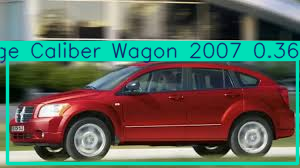

In [81]:
results[0].show()

**Observation**
- **The Car model is predicted correctly however the year is different**

In [82]:
results = model("fordmustang2025.jpg")


image 1/1 /home/ec2-user/SageMaker/fordmustang2025.jpg: 384x640 1 Ferrari 458 Italia Coupe 2012, 9.2ms
Speed: 1.2ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


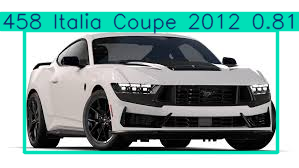

In [83]:
results[0].show()

**Observation**
- **The Car model predicted is incorrect**
- **the car is for Ford Mustang 2025**

**Conclusion**
- **The prediction by the model on untrained images is not that accurate, however for trained images it is correct**

**Test Metrics**

In [86]:
pd.DataFrame([test_metrics.results_dict]).to_csv("test_metrics.csv", index=False)

In [87]:
df = pd.read_csv("test_metrics.csv")
print(df.T)  # Transpose for easier viewing

                             0
metrics/precision(B)  0.932217
metrics/recall(B)     0.910020
metrics/mAP50(B)      0.949185
metrics/mAP50-95(B)   0.898625
fitness               0.903681


**Saving the trained Model later use**

In [88]:
best_model = YOLO("runs/detect/train/weights/best.pt")

In [89]:
os.makedirs("my_models", exist_ok=True)
best_model.save("my_models/yolo_car_detector_best.pt")